In [ ]:
! pip install 'h5py==2.10.0' --force-reinstall

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
#Run this twice to install correct version of keras

!pip install -U keras==2.1.5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached Keras-2.1.5-py2.py3-none-any.whl (334 kB)
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0


In [ ]:
import tensorflow
import skimage
import keras
print(tensorflow.__version__,  skimage.__version__, keras.__version__)
import os
import cv2
import numpy as np
import imageio
from scipy import ndimage
from glob import glob
import zipfile
from keras.layers import Conv2DTranspose
from keras.layers import BatchNormalization
from keras.layers import concatenate
from keras.layers import UpSampling2D, Conv2D, Activation, Input, Dropout, MaxPooling2D
from keras.models import Model
from keras import backend as K
from keras.layers.core import Lambda
from keras.utils import normalize
from matplotlib import pyplot as plt

Using TensorFlow backend.


1.15.2 0.18.3 2.1.5


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
IMG_ROWS = 256
IMG_COLS = 256
n_classes=4 #Number of classes for segmentation

In [ ]:
batch_size = 8

os.chdir("/content/drive/MyDrive/1_ImplantProject/dataset_unet_multiclasses/")
!pwd
path = "/content/drive/MyDrive/1_ImplantProject/dataset_unet_multiclasses/"
img_dir = "./train/"
mask_dir = "./masks/"


/content/drive/MyDrive/1_ImplantProject/dataset_unet_multiclasses


In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

################################################################
def multi_unet_model(n_classes=4, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    #NOTE: Compile the model in the main program to make it easy to test with various loss functions
    #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    #model.summary()
    
    return model
 

In [ ]:
#If starting with pre-trained weights. 
model = multi_unet_model(n_classes=n_classes, IMG_HEIGHT=256, 
                            IMG_WIDTH=256, IMG_CHANNELS=1)
model.load_weights(path + '/implant_test.hdf5')

In [ ]:
def calculateProbabilityOnPredictedImage(predicted_img):
    unique, counts = np.unique(predicted_img, return_counts=True)
    dic = dict(zip(unique, counts))
    total = sum(dic.values())  - dic.get(0)
    # 1 = bego, 2 = bicon, 3 = straumann
    if total > 0:
        if dic.get(1) is not None:
            prob_bego = dic.get(1)/total
        else:
            prob_bego = 0
            
        if dic.get(2) is not None:
            prob_bicon = dic.get(2)/total
        else:
            prob_bicon = 0
        
        if dic.get(3) is not None:
            prob_straumann = dic.get(3)/total
        else:
            prob_straumann = 0
    else:
        prob_bego = 0
        prob_bicon = 0
        prob_straumann = 0
        
    prob_dic = dict(zip(['bego', 'bicon', 'straumann'], [prob_bego, prob_bicon, prob_straumann]))
    return prob_dic


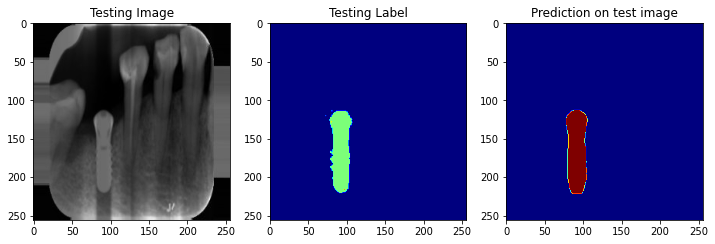

groud_truth {0: 63194, 1: 2340, 2: 2}
pred_label {0: 63035, 1: 2501}


{'bego': 1.0, 'bicon': 0, 'straumann': 0}

In [ ]:
import random
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='jet')
plt.show()

# print(np.unique(predicted_img))
# print(np.unique(prediction))

unique, counts = np.unique(ground_truth, return_counts=True)
print('groud_truth', dict(zip(unique, counts)))
unique, counts = np.unique(predicted_img, return_counts=True)
print('pred_label', dict(zip(unique, counts)))
#####################################################################
# test_result = calculateProbabilityForTestingImage(ground_truth, predicted_img)
calculateProbabilityOnPredictedImage(predicted_img)

In [ ]:
test_new_img_path = path + "/new_test/"
text_result = []
for directory_path in glob(test_new_img_path):
    print(directory_path)
    for test_new_img_path in glob(directory_path + "/**/*.jpg",recursive=True):
        # print(test_new_img_path)
        new_img = cv2.imread(test_new_img_path, 0)       
        new_img = cv2.resize(new_img, (IMG_ROWS, IMG_COLS))
        
        test_img_norm = normalize(new_img)
        test_img_input = np.expand_dims(test_img_norm, 0)
        test_img_input = np.expand_dims(test_img_input, 3)
        prediction = (model.predict(test_img_input))
        predicted_img=np.argmax(prediction, axis=3)[0,:,:]
        cal_rel = calculateProbabilityOnPredictedImage(predicted_img)
        #print(cal_rel)
        ap_text = test_new_img_path + ',' + str(cal_rel)
        text_result.append(ap_text)

import pandas as pd

df = pd.DataFrame(text_result)
df.to_csv('./text_result.csv')

In [ ]:
# 3. Use scikit-learn to get statistics
from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns
import matplotlib.pyplot as plt  

def confusion_pre_recall_f1(input_model, title):
  print(title)
  cm1 = confusion_matrix(input_model.true_label, input_model.predict_label)
  print(cm1)
  print("-"*30)
  report1 = classification_report(input_model.true_label, input_model.predict_label)
  print(report1)
  print("-"*30)
  ax= plt.subplot()
  sns.heatmap(cm1, annot=True, fmt='g', ax=ax);
  # labels, title and ticks
  ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
  ax.set_title(title); 
  ax.xaxis.set_ticklabels(['Bego', 'Bicon', 'Straumann']); ax.yaxis.set_ticklabels(['Bego', 'Bicon', 'Straumann']);